# Cell Capsule Analysis
This notebook analyses images of cell capsules to...
Images must be marked with a green ellipse to denote the cell wall.
This script then identifies the maximum distance between the cell wall and the cell capsule, and adds a second red ellipse.

The area between the red and green ellipses is then calculated in pixels, before being converted to microns using the scale bar contained in each image.
Further statistics are then calculated, such as the ratio of cell area to cell capsule area.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from ipywidgets import Layout

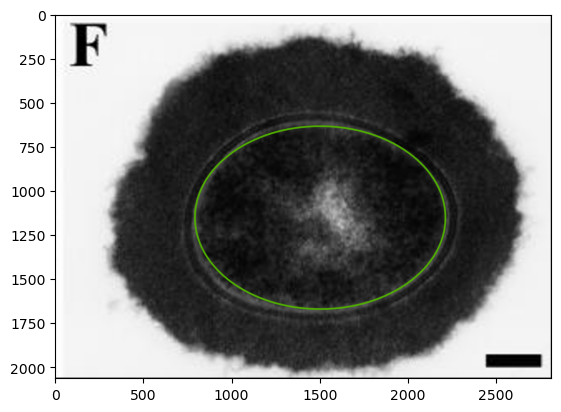

In [2]:
image_path = 'images/AnnotatedSample.png'

# Read the image
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

imageOriginal = image.copy()

#  show the original image
plt.imshow(imageOriginal)

Analyse the image to find the green outline of the cell, and show the mask produced

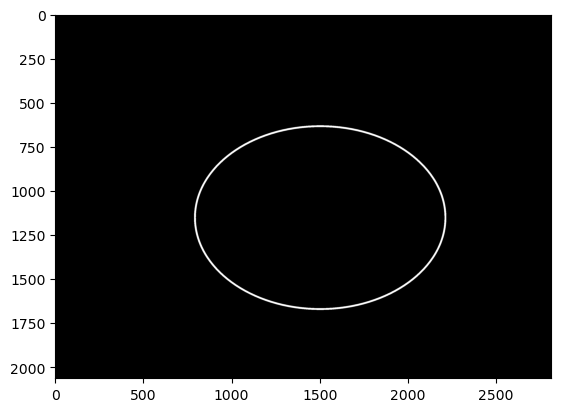

In [3]:
# Define range for green color in HSV
lower_green = (35, 50, 50)
upper_green = (85, 255, 255)

# Threshold the image to get only green
green_mask = cv2.inRange(hsv, lower_green, upper_green)

# call imshow() using plt object
plt.imshow(green_mask, cmap='gray')
  
# display that image
plt.show()

Now fit an ellipse to the masked image, so that the centre of the cell outline can be found.
Add a red cross to the image to mark the centre point.

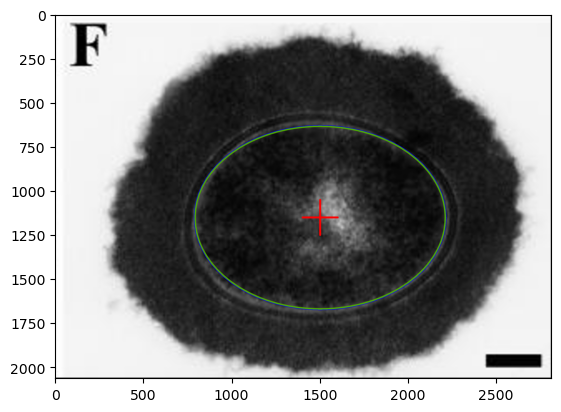

In [71]:
# Find contours
contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is our green outline, sort contours by area
contour = max(contours, key=cv2.contourArea)

# Fit an ellipse to the contour
ellipse = cv2.fitEllipse(contour)
(xc, yc), (d1, d2), angle = ellipse

# draw the fitted ellipse over the original image in red
imageEllipse = imageOriginal.copy()
cv2.ellipse(imageEllipse, ellipse, (0, 0, 255), 2)

# draw the center of the ellipse in red with a cross
cv2.line(imageEllipse, (int(xc) - 100, int(yc)), (int(xc) + 100, int(yc)), (255, 0, 0), 10)
cv2.line(imageEllipse, (int(xc), int(yc) - 100), (int(xc), int(yc) + 100), (255, 0, 0), 10)

# show the image
plt.imshow(imageEllipse)

With the cell centre and cell outline defined, start determining the maximum distance between the cell outline and the edge of the cell capsule.

Find the maximum distance between the cell wall and the cell capsule. Iterate through 360 degrees for the following steps:
1) Draw a blue line at 'x' degrees from the cell centre to the edge of the image.
2) create a mask using blue pixels produced by this line
3) combine this mask with a mask of white pixels in the image (cell capsule edge)
4) Of the remaining, non-zero pixels, calculate which is closest to the centre of the cell
5) calculate the distance between the closest non-zero pixel and the centre of the cell, and add to a list



In [72]:
#  create a list of distances between the cell wall and the cell capsule at each angle
cellWallToCellCapsuleDistances = []
#  create a list of points defining the outline of the cell capsule
cellCapsuleOutline = []
#  create a list of points defining the outline of the cell wall
cellWallOutline = []

# Define range for white color in HSV
lower_white = (200,200,200)
upper_white = (255, 255, 255)

# Define range for blue color in RGB
lower_blue = (0,0,250)
upper_blue = (0,0,255)

# start with a fresh copy of the original image
imageExpandedOutline = imageOriginal.copy()

# Threshold the HSV image to get only white colors
white_mask = cv2.inRange(imageExpandedOutline, lower_white, upper_white)

# iterate through 360 degrees of rotation at 1 degree intervals
for i in range(0, 360, 1):
    # create a copy of the original image
    imageExpandedOutline = imageOriginal.copy()

    # find the width and height of the image
    (h, w) = imageExpandedOutline.shape[:2]

    # draw a line from the centre point to the edge of the ellipse in blue at the current angle
    cv2.line(imageExpandedOutline, (int(xc), int(yc)), (int(xc + w * np.cos(i * np.pi / 180)), int(yc + h * np.sin(i * np.pi / 180))), (0, 0, 255), 4)

    # Threshold the HSV image to get only white colors
    blue_mask = cv2.inRange(imageExpandedOutline, lower_blue, upper_blue)

    # combine the white and blue masks to get the intersection of the new line with the outline of the ellipse
    combined_mask = cv2.bitwise_and(blue_mask, white_mask)

    # find the co-ordinates non zero pixels in the combined mask
    nonZeroPixels = np.where(combined_mask == 255)

    #  find the distance from the centre of the ellipse to each of the non zero pixels
    distances = np.sqrt((nonZeroPixels[0] - xc) ** 2 + (nonZeroPixels[1] - yc) ** 2)

    # find the index of the closest point
    closest_index = np.argmin(distances)

    # add the shortest distance to the list of points defining the outline of the cell capsule
    centreToCapsuleOutlineDistance = distances[closest_index]

    # find the x and y co-ordinates of the closest point on the cell capsule to the cell centre (for plotting only)
    closest_x = nonZeroPixels[1][closest_index]
    closest_y = nonZeroPixels[0][closest_index]

    # add closest x and y to a list of points defining the outline of the cell capsule (for plotting only)
    cellCapsuleOutline.append((closest_x, closest_y))

    # combine the blue and green masks to get the intersection of the new line with the outline of the green ellipse
    combined_mask = cv2.bitwise_and(green_mask, blue_mask)

    # find the co-ordinates of the intersection
    intersect_y, intersect_x = np.where(combined_mask == 255)

    cellWallOutline.append((intersect_x[0], intersect_y[0]))

    # find the absolute distance between co-ordinates of the cell wall and the cell capsule
    centreToCellOutlineDistance = np.sqrt((intersect_x[0] - closest_x) ** 2 + (intersect_y[0] - closest_y) ** 2)

    # add the distance to the list of distances between the cell outline and the cell capsule outline
    cellWallToCellCapsuleDistances.append(centreToCellOutlineDistance)

# set that are less than zero to zero
# cellWallToCellCapsuleDistances = np.array(cellWallToCellCapsuleDistances)
# cellWallToCellCapsuleDistances[cellWallToCellCapsuleDistances < 0] = 0


# apply a low pass filter to the list of distances between the cell outline and the cell capsule outline
cellWallToCellCapsuleDistancesFiltered = np.convolve(cellWallToCellCapsuleDistances, np.ones(2), 'valid') / 2



In [73]:
# create an interractive plot of the distances between the cell outline and the cell capsule outline

# create a slider for the angle of the blue line
def updateAngle(angle):
    originalImageWithAngles = imageOriginal.copy()
    
    # find the width and height of the image
    (h, w) = originalImageWithAngles.shape[:2]

    # draw a dotted line from the centre point to the edge of the ellipse in red at the current angle
    cv2.line(originalImageWithAngles, (int(xc), int(yc)), (cellCapsuleOutline[angle][0], cellCapsuleOutline[angle][1]), (255, 0, 0), 4)
    
    # add a circle at the edge of the cell capsule
    cv2.circle(originalImageWithAngles, (cellCapsuleOutline[angle][0], cellCapsuleOutline[angle][1]), 20, (255, 0, 0), 4)

    # add a circle at the edge of the cell wall
    cv2.circle(originalImageWithAngles, (cellWallOutline[angle][0], cellWallOutline[angle][1]), 20, (255, 0, 0), 4)

    # create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.plot(cellWallToCellCapsuleDistances)
    ax1.plot(cellWallToCellCapsuleDistancesFiltered)
    # plot a verical line at the current angle
    ax1.axvline(x=angle, color='r', linestyle='--')
    # plot a horizontal line at the current distance
    ax1.axhline(y=cellWallToCellCapsuleDistances[angle], color='r', linestyle='--')
    ax1.set_xticks(np.arange(0, 360, 45))
    ax1.set_title('Distance from centre to cell capsule outline vs angle')
    ax1.set_xlabel('Angle (degrees)')
    ax1.set_ylabel('Distance (pixels)')
    ax2.imshow(originalImageWithAngles)
    ax2.set_title('Original image')

    plt.show()
    

widgets.interact(updateAngle, angle=widgets.IntSlider(value=0,min=0,max=359,step=1,description="Angle :",layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='Angle :', layout=Layout(width='1000px'), max=359), Outpu…

<function __main__.updateAngle(angle)>

In [74]:
# find the maximum distance from the centre to the cell capsule outline and the angle at which it occurs using the filtered data
maxDistance = max(cellWallToCellCapsuleDistances)
maxDistanceIndex = np.argmax(cellWallToCellCapsuleDistances)
maxDistanceAngle = maxDistanceIndex * 1

In [75]:
#  create a list of points on the outline of the new expanded ellipse
expandedOutlinePoints = []

# Define range for blue color in HSV
lower_blue = (0,0,200)
upper_blue = (0,0,255)

# iterate through 360 degrees of rotation at 1 degree intervals
for i in range(0, 360, 1):
    # create a copy of the original image
    imageExpandedOutline = imageOriginal.copy()

    # find the width and height of the image
    (h, w) = imageExpandedOutline.shape[:2]

    # draw a line from the centre point to the edge of the ellipse in blue at the current angle
    cv2.line(imageExpandedOutline, (int(xc), int(yc)), (int(xc + w * np.cos(i * np.pi / 180)), int(yc + h * np.sin(i * np.pi / 180))), (0, 0, 255), 4)

    # Threshold the HSV image to get only blue colors
    blue_mask = cv2.inRange(imageExpandedOutline, lower_blue, upper_blue)

    # combine the blue and green masks to get the intersection
    combined_mask = cv2.bitwise_and(green_mask, blue_mask)

    # find the co-ordinates of the intersection
    intersect_x, intersect_y = np.where(combined_mask == 255)

    #  get the co-ordinates of the point 'x' pixels from the intersection at the current angle
    x = maxDistance

    # store the co-ordinates of the point 'x' pixels from the intersection at the current angle
    outlinePoint = int(intersect_y[0] + x * np.cos(i * np.pi / 180)), int(intersect_x[0] + x * np.sin(i * np.pi / 180))
    expandedOutlinePoints.append(outlinePoint)


use the expanded outline points to draw the new expanded outline of the ellipse

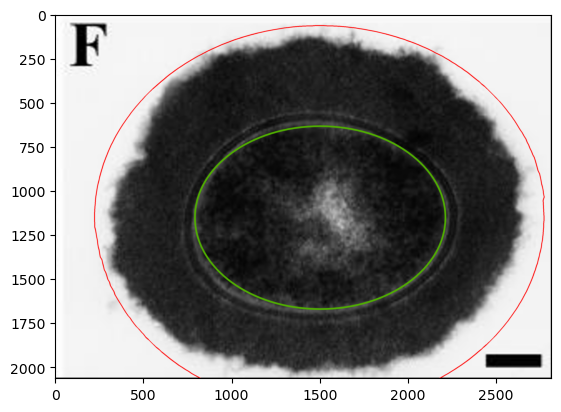

In [76]:
#  create a copy of the original image to draw the outline points on
imageExpandedOutline = imageOriginal.copy()

#  draw a line between each of the outline points in red by iterating through the list of points
for i in range(0, len(expandedOutlinePoints) - 1):
    cv2.line(imageExpandedOutline, expandedOutlinePoints[i], expandedOutlinePoints[i + 1], (255, 0, 0), 4)

#  draw a line between the first and last points in red
cv2.line(imageExpandedOutline, expandedOutlinePoints[0], expandedOutlinePoints[len(expandedOutlinePoints) - 1], (255, 0, 0), 4)

### Cell capsule and cell wall limits have been drawn, resize the image back to its original resolution, display it, and save it to the outputs folder

True

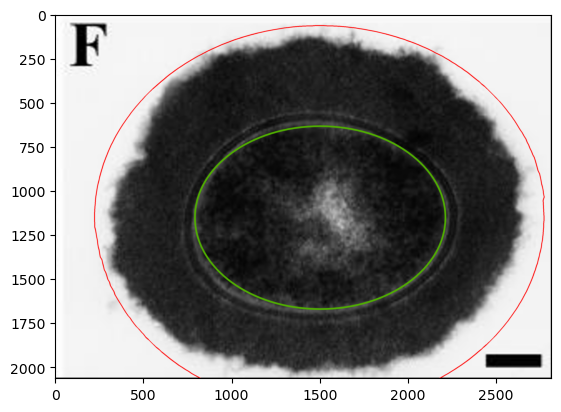

In [77]:
# resize the image back to its original size
imageExpandedOutline = cv2.resize(imageExpandedOutline, (imageOriginal.shape[1], imageOriginal.shape[0]))

#  show the image
plt.imshow(imageExpandedOutline)

# check if the output directory is emtpy
if len(os.listdir('outputimages')) == 0:
    #  if it is empty, set the file name number to 0
    imageNumber = 0
else:
    #  find the last image in the folder
    lastImage = max([int(f.split('.')[0]) for f in os.listdir('outputimages')])
    #  increment the file name number
    imageNumber = lastImage + 1

#  create a path to the output image
outputImagePath = 'outputimages/' + str(imageNumber) + '.png'

#  save the image
cv2.imwrite(outputImagePath, imageExpandedOutline)

### With the cell capsule limit defined in red, and the cell wall limit defined in green, we can start calculating the areas of these regions

In [78]:
# Create a function to count the number of pixels between the circles

def calculateAreasInPixels(img):

    # Convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for red and green colors
    lower_red1 = np.array([250, 0, 0])
    upper_red1 = np.array([255, 0, 0])

    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create masks
    mask_red = cv2.inRange(img, lower_red1, upper_red1)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours
    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour for each color is the required circle, sort and pick the largest
    contour_red = max(contours_red, key=cv2.contourArea)
    contour_green = max(contours_green, key=cv2.contourArea)

    # fit an elipse to the contour
    ellipse_red = cv2.fitEllipse(contour_red)

    ellipseImg = img.copy()
    # draw the fitted ellipse over the original image in red, with a solid infill
    cv2.ellipse(ellipseImg, ellipse_red, (255, 0, 0), thickness=cv2.FILLED)

    # create a mask of the ellipse
    mask_red_filled = cv2.inRange(ellipseImg, (255, 0, 0), (255, 0, 0))

    mask_green_filled = np.zeros_like(mask_green)
    cv2.drawContours(mask_green_filled, [contour_green], -1, (255), thickness=cv2.FILLED)

    # invert the green mask so that the region between the circles is white
    invt_mask_green_filled = cv2.bitwise_not(mask_green_filled)

    # find the region between the red and green filled masks
    between_circles = cv2.bitwise_and(mask_red_filled, invt_mask_green_filled)

    # invert the white mask to add the cell outline to the image
    invt_WhiteMask = cv2.bitwise_not(white_mask)

    # add the cell outline to the image
    between_circles = cv2.bitwise_and(between_circles, invt_WhiteMask)

    # create a plot showing the original image and the mask of the region between the circles
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(img)
    ax1.set_title('Original image')
    ax2.imshow(between_circles, cmap='gray')
    ax2.set_title('Mask of region between circles')

    plt.show()

    # Count the non-zero pixels
    cellAreaPixels = cv2.countNonZero(mask_green_filled)
    totalAreaPixels = cv2.countNonZero(invt_WhiteMask)
    capsuleAreaPixels = cv2.countNonZero(between_circles)

    return cellAreaPixels, capsuleAreaPixels, totalAreaPixels

In [79]:
def is_rectangle(cnt, epsilon_factor=0.02):
    # Approximate the contour to determine its shape
    epsilon = epsilon_factor * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # If the shape has 4 vertices, it's potentially a rectangle
    return len(approx) == 4

In [80]:
def measure_black_rectangle_width(img):

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Threshold to isolate black objects
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  

    # Find black contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over each contour to find the rectangle
    for cnt in contours:
        if is_rectangle(cnt):
            # Get the width of the bounding rectangle of the contour
            _, _, width, _ = cv2.boundingRect(cnt)
            return width

    # If no rectangle is found
    return 0

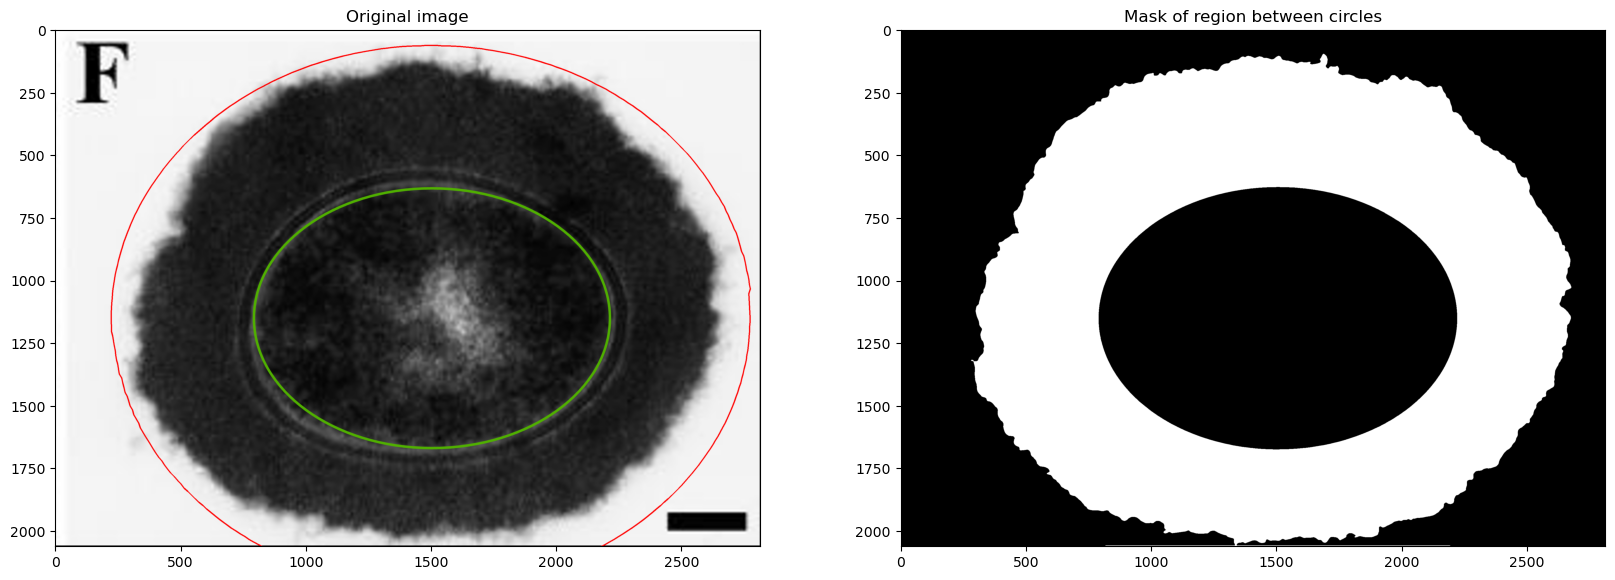

In [81]:
cellAreaPixels, capsuleAreaPixels, totalAreaPixels = calculateAreasInPixels(imageExpandedOutline)
pixelWidthOfBlackRectangle = measure_black_rectangle_width(imageExpandedOutline)

In [82]:
blackBoxWidthInMicrons = 0.1
pixelSizeInMicrons = blackBoxWidthInMicrons / pixelWidthOfBlackRectangle

# Calculate area in um^2 to 3 decimal places
cellAreaInUm = round(cellAreaPixels * pixelSizeInMicrons, 3)
capsuleAreaInUm = round(capsuleAreaPixels * pixelSizeInMicrons, 3)
totalAreaInUm = round(totalAreaPixels * pixelSizeInMicrons, 3)

# Print results rounded to x decimal places
dp = 6
print(f'Cell Area In um: {round(cellAreaInUm,dp)} um^2 ({round(cellAreaPixels,dp)} pixels)')
print(f'Capsule Area In um: {round(capsuleAreaInUm,dp)} um^2 ({round(capsuleAreaPixels,dp)} pixels)')
print(f'Total Area In um: {round(totalAreaInUm,dp)} um^2 ({round(totalAreaPixels,dp)} pixels)')
print(f'Ratio of capsule area to cell area: {round(capsuleAreaInUm / cellAreaInUm,dp)}')
print(f'Ratio of total area to cell area: {round(totalAreaInUm / cellAreaInUm,dp)}')
print(f'Ratio of capsule area to total area: {round(capsuleAreaInUm / totalAreaInUm,dp)}')
print(f'Ratio of cell area to total area: {round(cellAreaInUm / totalAreaInUm,dp)}')
print(f'Pixel size: {round(pixelSizeInMicrons,dp)} um')



Cell Area In um: 41.804 um^2 (1176373 pixels)
Capsule Area In um: 86.141 um^2 (2424010 pixels)
Total Area In um: 130.336 um^2 (3667654 pixels)
Ratio of capsule area to cell area: 2.060592
Ratio of total area to cell area: 3.117788
Ratio of capsule area to total area: 0.660915
Ratio of cell area to total area: 0.32074
Pixel size: 3.6e-05 um
